# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dl_portfolio.ae_data import load_data
from dl_portfolio.backtest import plot_perf, backtest_stats, get_target_vol_other_weights
import pickle
import os, sys
from sklearn.neighbors import KernelDensity
import seaborn as sns
from sklearn import metrics as skmetrics
from dl_portfolio.sensitivity import plot_sensitivity

# Some useful functions

In [19]:
def classification_metrics(cv_signal: dict, target):
    stats = {}
    for factor in target.columns:
        recall = []
        precision = []
        f1 = []
        tpr = []
        for cv in cv_signal:
            cv_dates = cv_signal[cv].index
            true = (target.loc[cv_dates, factor] == 0).astype(int)
            pred = (cv_signal[cv][factor] == 0).astype(int)
            
            print("support: ", np.sum(true))
            print("pred support: ", np.sum(pred))
            
            f1.append(skmetrics.f1_score(true, pred, labels=[0,1], average="weighted"))
            precision.append(skmetrics.precision_score(true, pred, labels=[0,1], average="weighted"))
            recall.append(skmetrics.recall_score(true, pred, labels=[0,1], average="weighted"))
            cm = skmetrics.confusion_matrix(true, pred, labels=[0,1])
            if (cm[1,0] + cm[1,1]) != 0:
                tpr.append(cm[1,1]/(cm[1,0] + cm[1,1]))
                print(cm)
                print(cm[1,1]/(cm[1,0] + cm[1,1]))


            
        stats[factor] = {"f1": f1, "precision": precision, "recall": recall, "tpr": tpr}
    return stats

def load_all_backtest_result(ae_dir, nmf_dir, dataset, m=0):
    # Load Market budget
    if dataset == 'bond':
        market_budget = pd.read_csv('data/market_budget_bond.csv', index_col=0)
        cryptos = ['BTC', 'DASH', 'ETH', 'LTC', 'XRP']
        market_budget = pd.concat([market_budget, pd.DataFrame(np.array([['crypto', 1]] * len(cryptos)),
                                                               index=cryptos,
                                                               columns=market_budget.columns)])
        # market_budget = market_budget.drop('CRIX')
        market_budget['rc'] = market_budget['rc'].astype(int)
    elif dataset in ["raffinot_multi_asset", "raffinot_bloomberg_comb_update_2021"]:
        market_budget = pd.read_csv('data/market_budget_raffinot_multiasset.csv', index_col=0)
        market_budget['rc'] = market_budget['rc'].astype(int)
    else:
        raise NotImplementedError()
   
    leverage = pd.read_csv(f'{ae_dir}/leverage.csv', index_col = 0)
    
    port_weights = pickle.load(open(f'{ae_dir}/portfolios_weights.p', 'rb'))
    hedge_port_weights = pickle.load(open(f'{ae_dir}/portfolios_weights_hedged_{m}.p', 'rb')) 
    for k in hedge_port_weights:
        port_weights[k + "_hedge"] = hedge_port_weights[k]
    
    nmf_port_weights = pickle.load(open(f'{nmf_dir}/portfolios_weights.p', 'rb'))
    for k in nmf_port_weights.keys():
        key = k.replace("ae", "nmf")
        port_weights[key] = nmf_port_weights[k]
        
    ann_perf = pd.read_csv(f'{ae_dir}/portfolios_returns.csv', index_col = 0)
    ann_perf.index = pd.to_datetime(ann_perf.index)
    hedged_perf = pd.read_csv(f'{ae_dir}/portfolios_returns_hedged_{m}.csv', index_col = 0)
    hedged_perf.index = pd.to_datetime(hedged_perf.index)
    hedged_perf.columns = [c +"_hedge" for c in hedged_perf.columns]
    ann_perf = pd.concat([ann_perf, hedged_perf], axis = 1)
    assert np.sum(ann_perf.isna().sum()) == 0, print(ann_perf.isna().sum())

    nmf_perf = pd.read_csv(f'{nmf_dir}/portfolios_returns.csv', index_col = 0)
    nmf_perf.index = pd.to_datetime(nmf_perf.index)
    nmf_perf.columns = [c.replace('ae', 'nmf') for c in nmf_perf.columns]
    common_cols = [c for c in nmf_perf.columns if "nmf" not in c]
    nmf_perf.drop(common_cols, 1, inplace = True)
    
    ann_perf = pd.concat([ann_perf, nmf_perf], 1)
    
    stats = backtest_stats(ann_perf, port_weights, period=252, market_budget=market_budget, sspw_tto=False)
    
    
    leverage_hedge = pd.read_csv(f'{ae_dir}/leverage_hedged_0.csv', index_col = 0)
    leverage_hedge.columns = [c +"_hedge" for c in leverage_hedge.columns]
    leverage = pd.concat([leverage, leverage_hedge], 1)

        
        
    return ann_perf, port_weights, leverage, stats


# Save directory

In [20]:
SAVE = True
savedir = "paper_result"
if SAVE:
    if not os.path.isdir(savedir):
        os.mkdir(savedir)

# Load tail events data

In [21]:
# Load tail events data
train_activation1 = pd.read_csv("activationProba/data/dataset1/train_linear_activation.csv", index_col = 0)
train_activation1.index = pd.to_datetime(train_activation1.index)
activation1 = pd.read_csv("activationProba/data/dataset1/linear_activation.csv", index_col = 0)
activation1.index = pd.to_datetime(activation1.index)
target1 = (activation1 > 0).astype(int)

train_activation2 = pd.read_csv("activationProba/data/dataset2/train_linear_activation.csv", index_col = 0)
train_activation2.index = pd.to_datetime(train_activation2.index)
activation2 = pd.read_csv("activationProba/data/dataset2/linear_activation.csv", index_col = 0)
activation2.index = pd.to_datetime(activation2.index)
target2 = (activation2 > 0).astype(int)



    
perf_ae_dir_1 = "./performance/test_final_models/ae/dataset1_20220224_131550"
perf_nmf_dir_1 = "./performance/test_final_models/nmf/dataset1_20220224_125019"
perf_ae_dir_2 = "./performance/test_final_models/ae/dataset2_20220224_132227"
perf_nmf_dir_2 = "./performance/test_final_models/nmf/dataset2_20220224_125329"

garch_dir_1 = "activationProba/output/dataset1/test/20220222142525_ec2_run_2"
garch_dir_2 = "activationProba/output/dataset2/test/20220222100230_ec2_run_1"

clusters1 = pickle.load(open(f"{perf_ae_dir_1}/cluster_assignment.p", "rb"))
signals1 = pickle.load(open(f"{perf_ae_dir_1}/hedging_signals_0.p", "rb"))
strats = list(signals1.keys())

clusters2 = pickle.load(open(f"{perf_ae_dir_2}/cluster_assignment.p", "rb"))
signals2 = pickle.load(open(f"{perf_ae_dir_2}/hedging_signals_0.p", "rb"))



pred_probas1 = pd.read_csv(f"{garch_dir_1}/activation_probas.csv",
                           index_col=0)
pred_probas1.index = pd.to_datetime(pred_probas1.index)
pred_probas2 = pd.read_csv(f"{garch_dir_2}/activation_probas.csv",
                           index_col=0)
pred_probas2.index = pd.to_datetime(pred_probas2.index)
# Handle R renaming of columns...
pred_probas1.columns = [c.replace(".", "-") for c in pred_probas1.columns]
pred_probas2.columns = [c.replace(".", "-") for c in pred_probas2.columns]
pred_probas1 = pred_probas1[activation1.columns] # to be safe
pred_probas2 = pred_probas2[activation2.columns] # to be safe


test_target1 = target1.loc[pred_probas1.index]
test_target2 = target2.loc[pred_probas2.index]


In [79]:
pred_probas2.head()

,SP500,EuroStox_Small,Gold,US-5Y,French-5Y
Index,,,,,
2007-02-02,0.000154,0.000013,0.000603,5.146152e-08,7.640257e-09
2007-02-05,0.000136,0.000016,0.000578,5.162043e-08,9.508905e-09
2007-02-06,0.000116,0.000013,0.000531,5.193701e-08,1.212971e-07
2007-02-07,0.000095,0.000011,0.000485,4.917785e-08,1.191520e-07
2007-02-08,0.000093,0.000011,0.000446,4.979151e-08,3.440508e-09


## Activation map

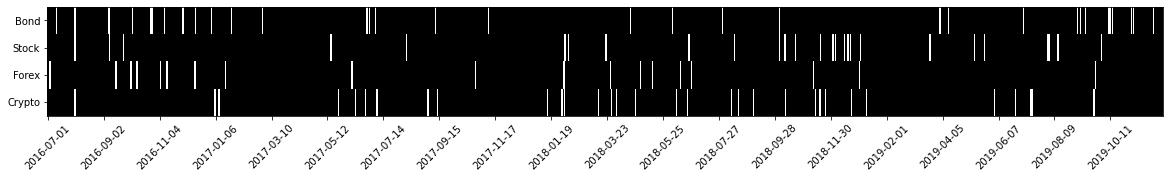

In [77]:
if SAVE:
    save_path=f'{savedir}/activation_map.png'
else:
    save_path = None
    
plot_sensitivity((train_activation1 <= 0).astype(int), 
                 figsize = (20,2),
                 max_xticks=20,
                 save_path=save_path)
_ = plt.yticks(range(4), ["Bond", "Stock", "Forex", "Crypto"])
if SAVE:
    plt.savefig(save_path, bbox_inches='tight', transparent=True)

# Backtest

In [23]:
ann_perf1, port_weights1, leverage1, stats1 = load_all_backtest_result(perf_ae_dir_1, 
                                                                       perf_nmf_dir_1,
                                                                       "bond")
dates1 = ann_perf1.index
ann_perf2, port_weights2, leverage2, stats2 = load_all_backtest_result(perf_ae_dir_2, 
                                                                       perf_nmf_dir_2,
                                                                       "raffinot_bloomberg_comb_update_2021")
dates2 = ann_perf2.index

Formatting table
Formatting table


## Backtest stats dataset 1

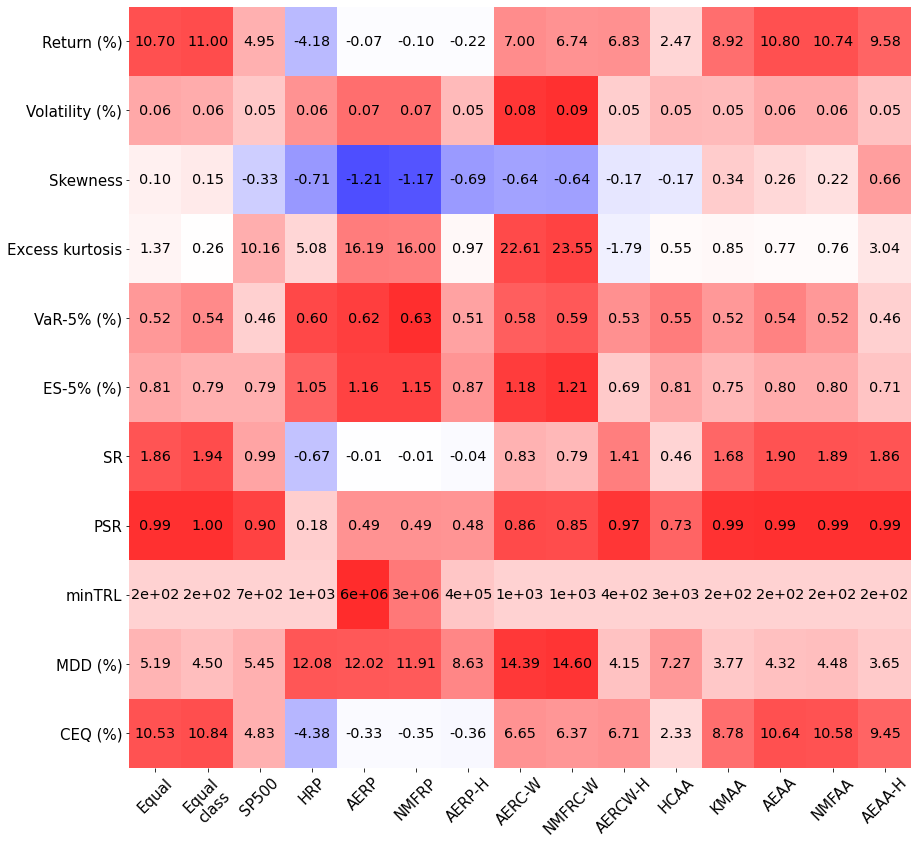

In [7]:
ORDER = ["equal", "equal_class", "SP500", "hrp", "aerp", "nmfrp", "aerp_hedge", "ae_rp_c", 
            "nmf_rp_c", "ae_rp_c_hedge", "hcaa", "kmaa", "aeaa", "nmfaa", "aeaa_hedge"]

XTICKLABELS = ["Equal", "Equal\nclass", "SP500", "HRP", "AERP", "NMFRP", "AERP-H",
               "AERC-W", "NMFRC-W", "AERCW-H", "HCAA", "KMAA", "AEAA", "NMFAA", "AEAA-H"]
# stats1.loc[['SP500', 'Russel2000', 'EuroStoxx50'], 'TTO'] = np.nan
pstats = stats1.drop(["Russel2000", "EuroStoxx50", "aeerc", "nmferc"])
pstats = pstats.loc[ORDER, :]


metrics = [c for c in list(pstats.columns) if c not in ['CR']]
fig, axs = plt.subplots(len(metrics), 1, figsize = (14,14), sharex = True)
i = 0
for i, c in enumerate(metrics):
    if c == "Return":
        cmap = "bwr"
    elif c == "Volatility":
        cmap="bwr"
        
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        yticklabel = c + ' (%)'
    else:
        yticklabel = c
        
    temp = pstats.loc[:, [c]].T
    
    min_ = min(temp.loc[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp.loc[c]) - np.std(temp.loc[c])
    sns.heatmap(temp,
                cmap='bwr', 
                center=center, 
                vmin=min(temp.loc[c]) - np.std(temp.loc[c]),
                vmax=max(temp.loc[c]) + np.std(temp.loc[c]),
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'x-large', 'ha': 'center'},
                yticklabels = [yticklabel],
                xticklabels = XTICKLABELS,
                cbar=False,
                ax=axs[i])    
    axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=15)

plt.subplots_adjust(hspace = .000)

if SAVE:
    plt.savefig(f'{savedir}/stats_heatmap_hedge_dataset1.png', bbox_inches='tight', transparent=True)

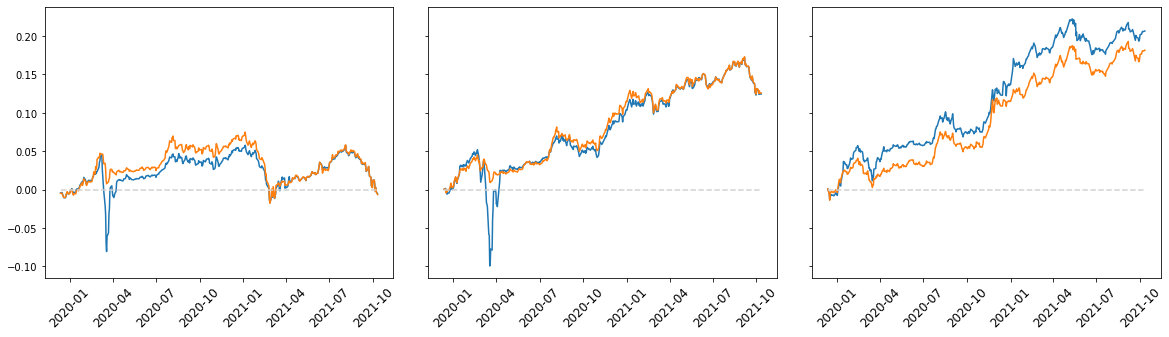

In [9]:
nrow, ncol = 2,2
fig, axs = plt.subplots(1, 3, figsize=(20,5), sharey=True, sharex=True)
for i, strat in enumerate([s for s in strats if s != "aeerc"]):
    axs[i].plot(np.cumprod(ann_perf1[strat] + 1) - 1)
    axs[i].plot(np.cumprod(ann_perf1[f"{strat}_hedge"] + 1) - 1)
    axs[i].plot(ann_perf1[strat] - ann_perf1[strat], linestyle="--", color="lightgrey")
    axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=12)
plt.subplots_adjust(wspace = .1)
plt.subplots_adjust(hspace = .1)

if SAVE:
    plt.savefig(f'{savedir}/perf_vs_hedge_dataset1.png', bbox_inches='tight', transparent=True)
plt.show()


## Backtest stats dataset 2

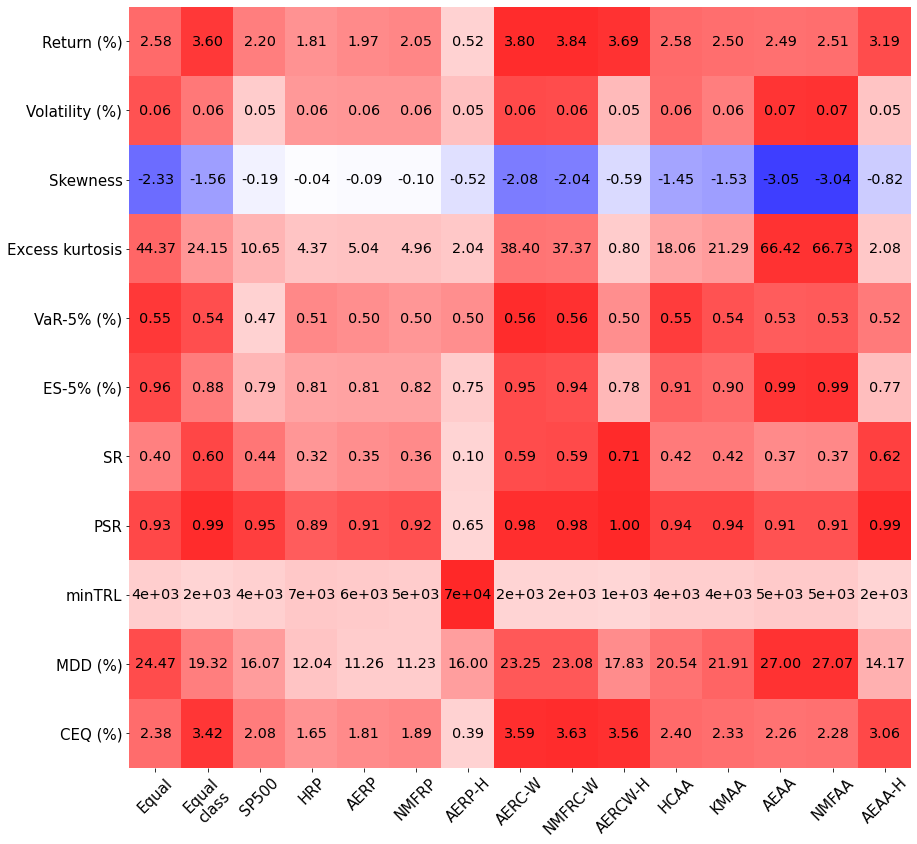

In [10]:
ORDER = ["equal", "equal_class", "SP500", "hrp", "aerp", "nmfrp", "aerp_hedge", "ae_rp_c", 
            "nmf_rp_c", "ae_rp_c_hedge", "hcaa", "kmaa", "aeaa", "nmfaa", "aeaa_hedge"]

XTICKLABELS = ["Equal", "Equal\nclass", "SP500", "HRP", "AERP", "NMFRP", "AERP-H",
               "AERC-W", "NMFRC-W", "AERCW-H", "HCAA", "KMAA", "AEAA", "NMFAA", "AEAA-H"]
# dataset1_stats.loc[['SP500', 'Russel2000', 'EuroStoxx50'], 'TTO'] = np.nan
pstats = stats2.drop(["Russel2000", "EuroStoxx50", "aeerc", "nmferc"])
pstats = pstats.loc[ORDER, :]


metrics = [c for c in list(pstats.columns) if c not in ['CR']]
fig, axs = plt.subplots(len(metrics), 1, figsize = (14,14), sharex = True)
i = 0
for i, c in enumerate(metrics):
    if c == "Return":
        cmap = "bwr"
    elif c == "Volatility":
        cmap="bwr"
        
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        yticklabel = c + ' (%)'
    else:
        yticklabel = c
        
    temp = pstats.loc[:, [c]].T
    
    min_ = min(temp.loc[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp.loc[c]) - np.std(temp.loc[c])
    sns.heatmap(temp,
                cmap='bwr', 
                center=center, 
                vmin=min(temp.loc[c]) - np.std(temp.loc[c]),
                vmax=max(temp.loc[c]) + np.std(temp.loc[c]),
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'x-large', 'ha': 'center'},
                yticklabels = [yticklabel],
                xticklabels = XTICKLABELS,
                cbar=False,
                ax=axs[i])    
    axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=15)

plt.subplots_adjust(hspace = .000)

if SAVE:
    plt.savefig(f'{savedir}/stats_heatmap_hedge_dataset2.png', bbox_inches='tight', transparent=True)

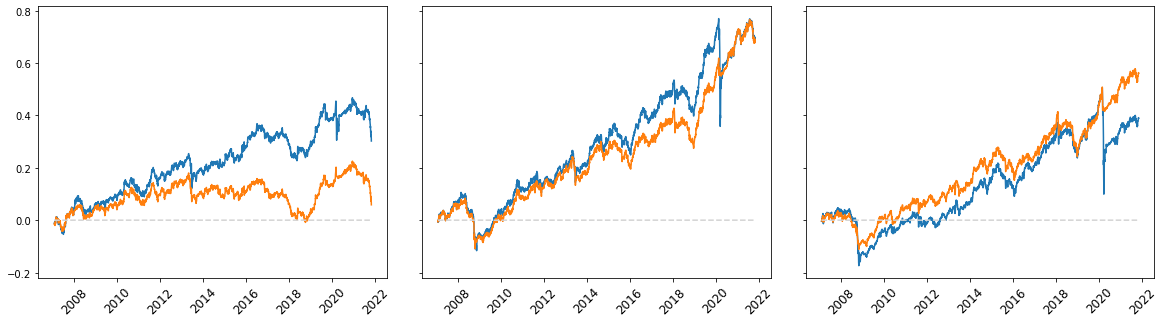

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20,5), sharey=True, sharex=True)
for i, strat in enumerate([s for s in strats if s != "aeerc"]):
    axs[i].plot(np.cumprod(ann_perf2[strat] + 1) - 1)
    axs[i].plot(np.cumprod(ann_perf2[f"{strat}_hedge"] + 1) - 1)
    axs[i].plot(ann_perf2[strat] - ann_perf2[strat], linestyle="--", color="lightgrey")
    axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=12)
plt.subplots_adjust(wspace = .1)
plt.subplots_adjust(hspace = .1)

if SAVE:
    plt.savefig(f'{savedir}/perf_vs_hedge_dataset2.png', bbox_inches='tight', transparent=True)
plt.show()


## Classification metrics dataset 1
### Labels

support:  1
pred support:  2
[[18  2]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  1
pred support:  6
[[14  5]
 [ 0  1]]
1.0
support:  2
pred support:  5
[[14  5]
 [ 2  0]]
0.0
support:  0
pred support:  2
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[21  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[17  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[17  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  1
pred support:  1
[[19  1]
 [ 1  0]]
0.0
support:  7
pred support:  11
[[7 6]
 [2 5]]
0.7142857142857143
support:  5
pred support:  21
[[ 0 16]
 [ 0  5]]
1.0
support:  2
pred support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

 0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  5
support:  1
pred support:  1
[[19  1]
 [ 1  0]]
0.0
support:  1
pred support:  7
[[13  6]
 [ 0  1]]
1.0
support:  3
pred support:  0
[[18  0]
 [ 3  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  3
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  15
[[ 7 14]
 [ 0  1]]
1.0
support:  0
pred support:  0
support:  2
pred support:  0
[[20  0]
 [ 2  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

 0
pred support:  0
support:  0
pred support:  2
support:  0
pred support:  2
support:  1
pred support:  1
[[18  1]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  3
[[17  3]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  3
pred support:  7
[[13  6]
 [ 2  1]]
0.3333333333333333
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  1
pred support:  0
[[17  0]
 [ 1  0]]
0.0


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


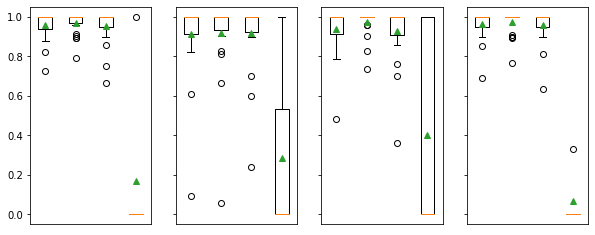

In [12]:
class_metrics1 = {}
strat = list(signals1.keys())[0]
class_metrics1 = classification_metrics(signals1[strat], target1)
factors = list(class_metrics1.keys())
fig, axs = plt.subplots(1, len(factors), figsize=(10, 4), sharey=True)
for i,f in enumerate(factors):
    axs[i].boxplot(class_metrics1[f].values(), showmeans=True)
    if SAVE:
        axs[i].set_xticks([])
    else:
        axs[i].set_xticklabels(stats)
        axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=12)

if SAVE:
    plt.savefig(f'{savedir}/class_metrics_hedged_aerp_w_dataset1.png', bbox_inches='tight',
                transparent=True)


# ROC Curve

AUC
        dataset1
GE_B    0.801114
SPX_X   0.807064
EUR_FX  0.782993
BTC     0.599478


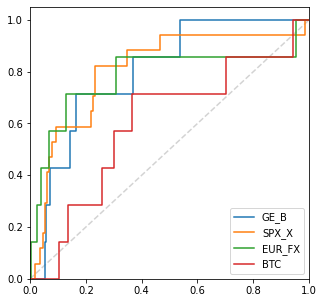

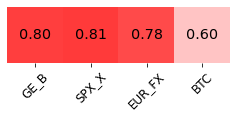

In [13]:
strat = "ae_rp_c"
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], color="lightgrey", linestyle="--")
roc_auc1 = {}
factors = list(pred_probas1.keys())
for f in factors:
    pred = pred_probas1[f].dropna()
    true = (target1.loc[pred.index, f] == 0).astype(int)
    fpr, tpr, _ = skmetrics.roc_curve(true, pred)
    roc_auc1[f] = skmetrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
if SAVE:
    plt.savefig(f'{savedir}/roc_curve_aerp_w_dataset1.png', bbox_inches='tight', 
                transparent=True)
plt.legend()

print("AUC")
roc_auc1 = pd.DataFrame(pd.Series(roc_auc1), columns=["dataset1"])
print(roc_auc1)

plt.figure(figsize=(4,8))
sns.heatmap(roc_auc1.T,
            cmap='bwr', 
            center=min(roc_auc1.values.reshape(-1)) - np.std(roc_auc1.values.reshape(-1)), 
            vmin=min(roc_auc1.values.reshape(-1)) - np.std(roc_auc1.values.reshape(-1)),
            vmax=max(roc_auc1.values.reshape(-1)) + np.std(roc_auc1.values.reshape(-1)),
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'color': 'black', 'size': 'x-large', 'ha': 'center'},
            cbar=False)
if SAVE:
    plt.yticks([])
    plt.tick_params(axis='x', labelrotation = 45,  labelsize=12)
    plt.savefig(f'{savedir}/auc_aerp_w_dataset1.png', bbox_inches='tight', 
                transparent=True)

plt.tick_params(axis='y', labelrotation = 0, labelsize=12)



## Classification metrics dataset 2
### Labels

support:  0
pred support:  0
support:  0
pred support:  20
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  5
support:  0
pred support:  0
support:  1
pred support:  0
[[21  0]
 [ 1  0]]
0.0
support:  2
pred support:  0
[[17  0]
 [ 2  0]]
0.0
support:  4
pred support:  0
[[18  0]
 [ 4  0]]
0.0
support:  0
pred support:  0
support:  4
pred support:  0
[[16  0]
 [ 4  0]]
0.0
support:  4
pred support:  0
[[18  0]
 [ 4  0]]
0.0
support:  2
pred support:  0
[[18  0]
 [ 2  0]]
0.0
support:  3
pred support:  0
[[17  0]
 [ 3  0]]
0.0
support:  3
pred support:  0
[[18  0]
 [ 3  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  4
pred support:  0
[[18  0]
 [ 4  0]]
0.0
support:  0
pred support:  0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  13
pred support:  1
[[ 9  0]
 [12  1]]
0.07692307692307693
support:  7
pred support:  14
[[4 8]
 [1 6]]
0.8571428571428571
support:  6
pred support:  0
[[16  0]
 [ 6  0]]
0.0
supp

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[19  0]
 [ 1  0]]
0.0
support:  2
pred support:  2
[[17  2]
 [ 2  0]]
0.0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  4
pred support:  0
[[18  0]
 [ 4  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  3
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  2
pred support:  10
[[10  9]
 [ 1  1]]
0.5
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[21  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  4
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  1
[[20  1]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

 0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  2
support:  7
pred support:  19
[[ 2 12]
 [ 0  7]]
1.0
support:  0
pred support:  2
support:  0
pred support:  0
support:  1
pred support:  1
[[19  1]
 [ 1  0]]
0.0
support:  0
pred support:  5
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  5
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  4
support:  2
pred support:  15
[[ 6 14]
 [ 1  1]]
0.5
support:  6
pred support:  5
[[9 4]
 [5 1]]
0

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/


0.0
support:  0
pred support:  0
support:  3
pred support:  0
[[17  0]
 [ 3  0]]
0.0
support:  6
pred support:  0
[[16  0]
 [ 6  0]]
0.0
support:  2
pred support:  0
[[18  0]
 [ 2  0]]
0.0
support:  3
pred support:  0
[[17  0]
 [ 3  0]]
0.0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  7
pred support:  8
[[9 6]
 [5 2]]
0.2857142857142857
support:  0
pred support:  0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  11
pred support:  0
[[11  0]
 [11  0]]
0.0
support:  6
pred support:  12
[[6 7]
 [1 5]]
0.8333333333333334
support:  2
pred support:  0
[[20  0]
 [ 2  0]]
0.0
support:  0
pred support:  0
support:  2
pred support:  4
[[13  4]
 [ 2  0]]
0.0
support:  2
pred support:  0
[[19  0]
 [ 2  0]]
0.0
support:  2
pred support:  0
[[19  0]
 [ 2  0]]
0.0
support:  2
pred support:  1
[[17  1]
 [ 2  0]]
0.0
support:  3
pred support:  0
[[18  0]
 [ 3  0]]
0.0
support:  0
pred suppor

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

[[11  5]
 [ 4  0]]
0.0
support:  1
pred support:  1
[[19  1]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  4
pred support:  0
[[18  0]
 [ 4  0]]
0.0
support:  3
pred support:  0
[[18  0]
 [ 3  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  1
pred support:  0
[[18  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  3
support:  0
pred support:  0
support:  0
pred support:  2
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[19  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  2
pred support:  5
[[15  4]
 [ 1  1]]
0.5
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  2
support:  0
pred support:  0
support:  1
pred support:  0
[[21  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

 0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  2
pred support:  2
[[15  2]
 [ 2  0]]
0.0
support:  7
pred support:  19
[[ 1 13]
 [ 1  6]]
0.8571428571428571
support:  1
pred support:  5
[[15  5]
 [ 1  0]]
0.0
support:  0
pred support:  2
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  1
pred support:  0
[[21  0]
 [ 1  0]]
0.0
support:  0
pred support:  1
support:  5
pred support:  0
[[17  0]
 [ 5  0]]
0.0
support:  0
pred support:  0
support:  2
pred support:  0
[[18  0]
 [ 2  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  5
pred support:  0
[[15  0]
 [ 5  0]]
0.0
support:  2
pred support:  0
[[19  0]
 [ 2  0]]
0.0
support:  2
pred support:  0
[[19  0]
 [ 2  0]]
0.0
support:  0
pred support:  0
support:  4
pred support:  7
[[12  6]
 [ 3  1]]
0.25
support:  0
pred support:  0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  11
pred support:  0
[[11  0]
 [11  0]]
0.0
support:  6
pred support:  12
[[6 7]
 [1 5]]
0.8333333333333334
support:  4
pred support:  8
[[11  7]
 [ 3  1]]
0.25
support:  0
pred support:  0
support:  0
p

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  2
pred support:  0
[[19  0]
 [ 2  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred sup

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

 0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  1
pred support:  0
[[18  0]
 [ 1  0]]
0.0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  1
[[19  1]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  2
support:  0
pred support:  0
support:  0


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  10
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[21  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred su

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

 0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  12
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  8
[[13  7]
 [ 0  1]]
1.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  1
[[18  1]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  17
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  2
pred support:  0
[[17  0]
 [ 2  0]]
0.0
support:  3
pred support:  0
[[19  0]
 [ 3  0]]
0.0
support:  0
pred support:  0
support:  7
pred support:  0
[[13  0]
 [ 7  0]]
0.0
support:  2
pred support:  0
[[20  0]
 [ 2  0]]
0.0
support:  0
pred support:  0
support:  4
pred support:  1
[[15  1]
 [ 4  0]]
0.0
support:  4
pred support:  0
[[17  0]
 [ 4  0]]
0.0
support:  1
pred support:  1
[[19  1]
 [ 1  0]]
0.0
support:  0
pred support:  0
support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/

 4
pred support:  0
[[18  0]
 [ 4  0]]
0.0
support:  0
pred support:  0
support:  2
pred support:  0
[[19  0]
 [ 2  0]]
0.0
support:  7
pred support:  0
[[15  0]
 [ 7  0]]
0.0
support:  2
pred support:  1
[[16  1]
 [ 2  0]]
0.0
support:  1
pred support:  0
[[21  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  3
pred support:  0
[[16  0]
 [ 3  0]]
0.0
support:  0
pred support:  0
support:  6
pred support:  8
[[7 8]
 [6 0]]
0.0
support:  2
pred support:  0
[[18  0]
 [ 2  0]]
0.0
support:  2
pred support:  1
[[18  1]
 [ 2  0]]
0.0
support:  3
pred support:  0
[[19  0]
 [ 3  0]]
0.0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[19  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
suppor

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  1
pred support:  1


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

[[20  1]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  4
support:  0
pred support:  2
support:  0
pred support:  0
support:  0
pred support:  3
support:  0
pred support:  0
support:  0
pred support:  11
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

 0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  2
[[18  2]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  3
pred support:  15
[[ 5 13]
 [ 1  2]]
0.6666666666666666
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-

 0
pred support:  0
support:  0
pred support:  9
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  2
pred support:  0
[[17  0]
 [ 2  0]]
0.0
support:  6
pred support:  0
[[16  0]
 [ 6  0]]
0.0
support:  0
pred support:  0
support:  3
pred support:  0
[[17  0]
 [ 3  0]]
0.0
support:  1
pred support:  0
[[21  0]
 [ 1  0]]
0.0
support:  0
pred support:  1
support:  3
pred support:  0
[[17  0]
 [ 3  0]]
0.0
support:  1
pred support:  0
[[20  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  7
pred support:  6
[[10  5]
 [ 6  1]]
0.14285714285714285
support:  0
pred support:  0
support:  0
pred support:  0
support:  5
pred support:  0
[[17  0]
 [ 5  0]]
0.0
support:  0
pred support:  0
support:  4
pred support:  0
[[18  0]
 [ 4  0]]
0.0
support:  0
pred support:  0
support:  2
pred support:  0
[[17  0]
 [ 2  0]]
0.0
support:  0
pred support:  0
support: 

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

 0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[19  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  7
support:  1
pred support:  0
[[19  0]
 [ 1  0]]
0.0
support:  2
pred support:  0
[[19  0]
 [ 2  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/

support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  2
pred support:  0
[[17  0]
 [ 2  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  2
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  1
[[19  1]
 [ 1  0]]
0

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  0
[[21  0]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  1
pred support:  3
[[17  3]
 [ 1  0]]
0.0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  18
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  7
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  4
pred support:  13
[[ 7 10]
 [ 1  3]]
0.75
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  1
support:  0
pred support:  0
support:  0
pred s

/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunospilak/miniconda3/envs/dl-

support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0
support:  0
pred support:  0


/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/brunospilak/miniconda3/envs/dl-portfolio/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


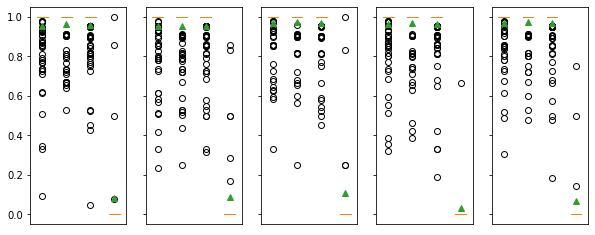

In [14]:
class_metrics2 = {}
strat = list(signals2.keys())[0]
class_metrics2 = classification_metrics(signals2[strat], target2)
factors = list(class_metrics2.keys())
fig, axs = plt.subplots(1, len(factors), figsize=(10, 4), sharey=True)
for i,f in enumerate(factors):
    axs[i].boxplot(class_metrics2[f].values(), showmeans=True)
    if SAVE:
        axs[i].set_xticks([])
    else:
        axs[i].set_xticklabels(stats)
        axs[i].tick_params(axis='x', labelrotation = 45,  labelsize=12)

if SAVE:
    plt.savefig(f'{savedir}/class_metrics_hedged_aerp_w_dataset2.png', bbox_inches='tight',
                transparent=True)


## ROC curve

AUC
                dataset2
SP500           0.883793
EuroStox_Small  0.877597
Gold            0.882934
US-5Y           0.887454
French-5Y       0.822004


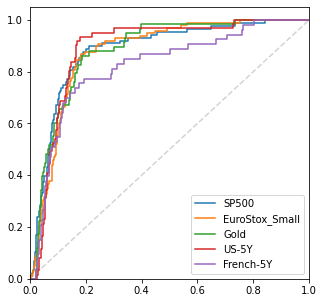

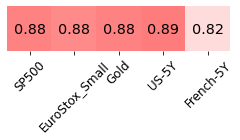

In [15]:
strat = "ae_rp_c"
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], color="lightgrey", linestyle="--")
roc_auc2 = {}
factors = list(pred_probas2.keys())
for f in factors:
    pred = pred_probas2[f].dropna()
    true = (target2.loc[pred.index, f] == 0).astype(int)
    fpr, tpr, _ = skmetrics.roc_curve(true, pred)
    roc_auc2[f] = skmetrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
if SAVE:
    plt.savefig(f'{savedir}/roc_curve_aerp_w_dataset2.png', bbox_inches='tight', 
                transparent=True)
plt.legend()

print("AUC")
roc_auc2 = pd.DataFrame(pd.Series(roc_auc2), columns=["dataset2"])
print(roc_auc2)

plt.figure(figsize=(4,8))
sns.heatmap(roc_auc2.T,
            cmap='bwr', 
            center=min(roc_auc2.values.reshape(-1))- np.std(roc_auc2.values.reshape(-1)), 
            vmin=min(roc_auc2.values.reshape(-1))- np.std(roc_auc2.values.reshape(-1)),
            vmax=max(roc_auc2.values.reshape(-1)) + np.std(roc_auc1.values.reshape(-1)),
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'color': 'black', 'size': 'x-large', 'ha': 'center'},
            cbar=False)
if SAVE:
    plt.yticks([])
    plt.tick_params(axis='x', labelrotation = 45,  labelsize=12)
    plt.savefig(f'{savedir}/auc_aerp_w_dataset2.png', bbox_inches='tight', 
                transparent=True)

plt.tick_params(axis='y', labelrotation = 0, labelsize=12)




# Exceedance and AUC

In [64]:
roc_auc = pd.concat([roc_auc1["dataset1"], roc_auc2["dataset2"]])
roc_auc = pd.DataFrame(roc_auc, columns=["AUC"]) * 100



pred1 = pd.DataFrame()
for cv in signals1["aerp"]:
    pred1 = pd.concat([pred1, signals1["aerp"][cv]])
pred1 = pred1[target1.columns]

pred2 = pd.DataFrame()
for cv in signals2["aerp"]:
    pred2 = pd.concat([pred2, signals2["aerp"][cv]])
pred2 = pred2[target2.columns]


exceedance1 = pd.DataFrame(index = ["true", "pred"], 
                           columns = pd.MultiIndex.from_product([["dataset1"], list(test_target1.columns)]))
exceedance1.loc["true", pd.IndexSlice["dataset1"]] = ((test_target1 == 0).sum()/len(test_target1)).values
exceedance1.loc["pred", pd.IndexSlice["dataset1"]] = ((pred1 == 0).sum()/len(test_target1)).values

exceedance2 = pd.DataFrame(index = ["true", "pred"], 
                           columns = pd.MultiIndex.from_product([["dataset2"], list(test_target2.columns)]))
exceedance2.loc["true", pd.IndexSlice["dataset2"]] = ((test_target2 == 0).sum()/len(test_target2)).values
exceedance2.loc["pred", pd.IndexSlice["dataset2"]] = ((pred2 == 0).sum()/len(test_target2)).values
exceedance = pd.concat([exceedance1, exceedance2], 1) * 100

excess = exceedance.diff().dropna().droplevel(0,1).astype(float)
excess = excess.T
excess.columns = ["Excess\nExceedance"]

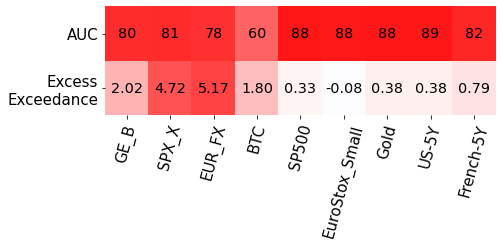

In [68]:
stats = pd.concat([roc_auc, excess], 1)
fig, axs = plt.subplots(len(stats.columns), 1, sharex = True, figsize = (7,2))
for i, stat in enumerate(list(stats.columns)):
    temp=stats[[stat]].T
    if stat == "AUC":
        fmt = ".0f"
    else:
        fmt = ".2f"
    sns.heatmap(temp,
                cmap='bwr', 
                center=0,
                vmin=min(temp.values.reshape(-1))- np.std(temp.values.reshape(-1)),
                vmax=max(temp.values.reshape(-1)) + np.std(temp.values.reshape(-1)),
                annot=True,
                fmt=fmt,
                annot_kws={'color': 'black', 'size': 'x-large', 'ha': 'center'},
                cbar=False,
                ax=axs[i])
    axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    axs[i].tick_params(axis='x', labelrotation = 75,  labelsize=15)

plt.subplots_adjust(hspace = .000)


_ = plt.yticks(range(4), ["Bond", "Stock", "Forex", "Crypto"])
if SAVE:
    plt.savefig(save_path, bbox_inches='tight', transparent=True)
    
    
if SAVE:
    plt.savefig(f'{savedir}/auc_exceedance.png', bbox_inches='tight', transparent=True)